## @author - Pardeep

## Using pretrained model (ResNet50) to classify a dog
- Keras Applications provided deep learning models with pre-trained weights
- Documentation: https://keras.io/applications/

### # import necessary library

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### importing Data

In [22]:
df_labels = pd.read_csv(r"/content/drive/MyDrive/Assisgnment/labels.csv")
df_labels['id'] = df_labels['id'] + '.jpg'
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [23]:
df_labels['breed'].unique().shape[0]

120

# Data Preprocessing

In [24]:
from sklearn.model_selection import train_test_split
df_train, df_validation = train_test_split(df_labels, test_size=0.2, shuffle=True)

In [25]:
df_train.shape , df_validation.shape

((8177, 2), (2045, 2))

### Preprocessing the Training set

## 1 Data Agumentation
Apply Only On train Data Only

In [26]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

training_set = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='/content/drive/MyDrive/Assisgnment/train',
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32
)


Found 8177 validated image filenames belonging to 120 classes.


### Preprocessing the val set

In [27]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = validation_datagen.flow_from_dataframe(
    dataframe=df_validation,
    directory='/content/drive/MyDrive/Assisgnment/train',
    x_col="id",
    y_col="breed",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=32
)

Found 2045 validated image filenames belonging to 120 classes.


## ResNet50

- ResNet-50 is a convolutional neural network that is trained on more than a million images from the ImageNet database. 

- The network is 50 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [28]:
# import necessary library
from keras.models import Sequential
from keras.layers import *

# Importing transfer learning model

### Load ResNet50 with imagenet weights
### image size can be calibrated with target_size parameter
### ResNet50 excepts the input with a size 224x224

In [29]:
model = tf.keras.applications.ResNet50V2(input_shape=[224,224,3], weights='imagenet', include_top=False)

# preprocessing pre trained model

In [30]:
for layer in model.layers:
    layer.trainable = False

## adding layer for flattening the outputs from previous layers

In [31]:
x = Flatten()(model.output)

## adding layer for classification

In [32]:
prediction = Dense(120, activation='softmax')(x)

In [33]:
from tensorflow.keras.models import Model

In [34]:
# create a model object
model = Model(inputs=model.input, outputs=prediction)

# Training the transfer learning model

### Compiling the CNN

In [35]:
model.compile(optimizer = 'adam', loss = 'CategoricalCrossentropy', metrics = ['accuracy'])

### To avoid model to overfitting we have to stop the training at certain level, So we have to introduce early stoping which stops the training when change in desired value stop incearsing after specified epochs

In [36]:
from keras.callbacks import EarlyStopping

In [37]:
earlystop = EarlyStopping(monitor='accuracy', patience=3, verbose=2, restore_best_weights=True)

### Training the CNN on the Training set and evaluating it on the Test set

In [38]:

STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=validation_set.n//validation_set.batch_size

In [39]:
a= model.fit(training_set, steps_per_epoch=STEP_SIZE_TRAIN, validation_data = validation_set, validation_steps=STEP_SIZE_VALID, callbacks= earlystop,epochs = 30)

Epoch 1/30
255/255 [==============================] - 615s 2s/step - loss: 23.9441 - accuracy: 0.3341 - val_loss: 28.7300 - val_accuracy: 0.5035
Epoch 2/30
255/255 [==============================] - 111s 436ms/step - loss: 12.4068 - accuracy: 0.7066 - val_loss: 29.4233 - val_accuracy: 0.5293
Epoch 3/30
255/255 [==============================] - 110s 433ms/step - loss: 8.5890 - accuracy: 0.8058 - val_loss: 32.5768 - val_accuracy: 0.5585
Epoch 4/30
255/255 [==============================] - 111s 435ms/step - loss: 6.6795 - accuracy: 0.8439 - val_loss: 34.4818 - val_accuracy: 0.5600
Epoch 5/30
255/255 [==============================] - 110s 430ms/step - loss: 5.3064 - accuracy: 0.8777 - val_loss: 38.6871 - val_accuracy: 0.5481
Epoch 6/30
255/255 [==============================] - 110s 433ms/step - loss: 4.9960 - accuracy: 0.8911 - val_loss: 39.7664 - val_accuracy: 0.5704
Epoch 7/30
255/255 [==============================] - 110s 433ms/step - loss: 4.5463 - accuracy: 0.9016 - val_loss: 42.

# Evaluating model on valdidation data on different evaluation metrix

In [40]:
val_loss, val_acc =model.evaluate(validation_set)
print("Val accuracy: ",val_acc*100)

64/64 [==============================] - 9s 140ms/step - loss: 62.3382 - accuracy: 0.6103
Val accuracy:  61.02689504623413


In [41]:
print("Val loss: ",val_loss)

Val loss:  62.33823776245117


In [42]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import itertools

In [43]:
Y_pred = model.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)

In [44]:
f_score = f1_score(validation_set.classes,y_pred,average='macro')
print('F1 score:',f_score)

F1 score: 0.007960634905890282


In [45]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(25,25))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
target_names = []
for key in training_set.class_indices:
    target_names.append(key)

In [47]:
Y_pred = model.predict(validation_set)
y_pred = np.argmax(Y_pred, axis=1)

In [48]:
cm = confusion_matrix(validation_set.classes,y_pred)

Normalized confusion matrix


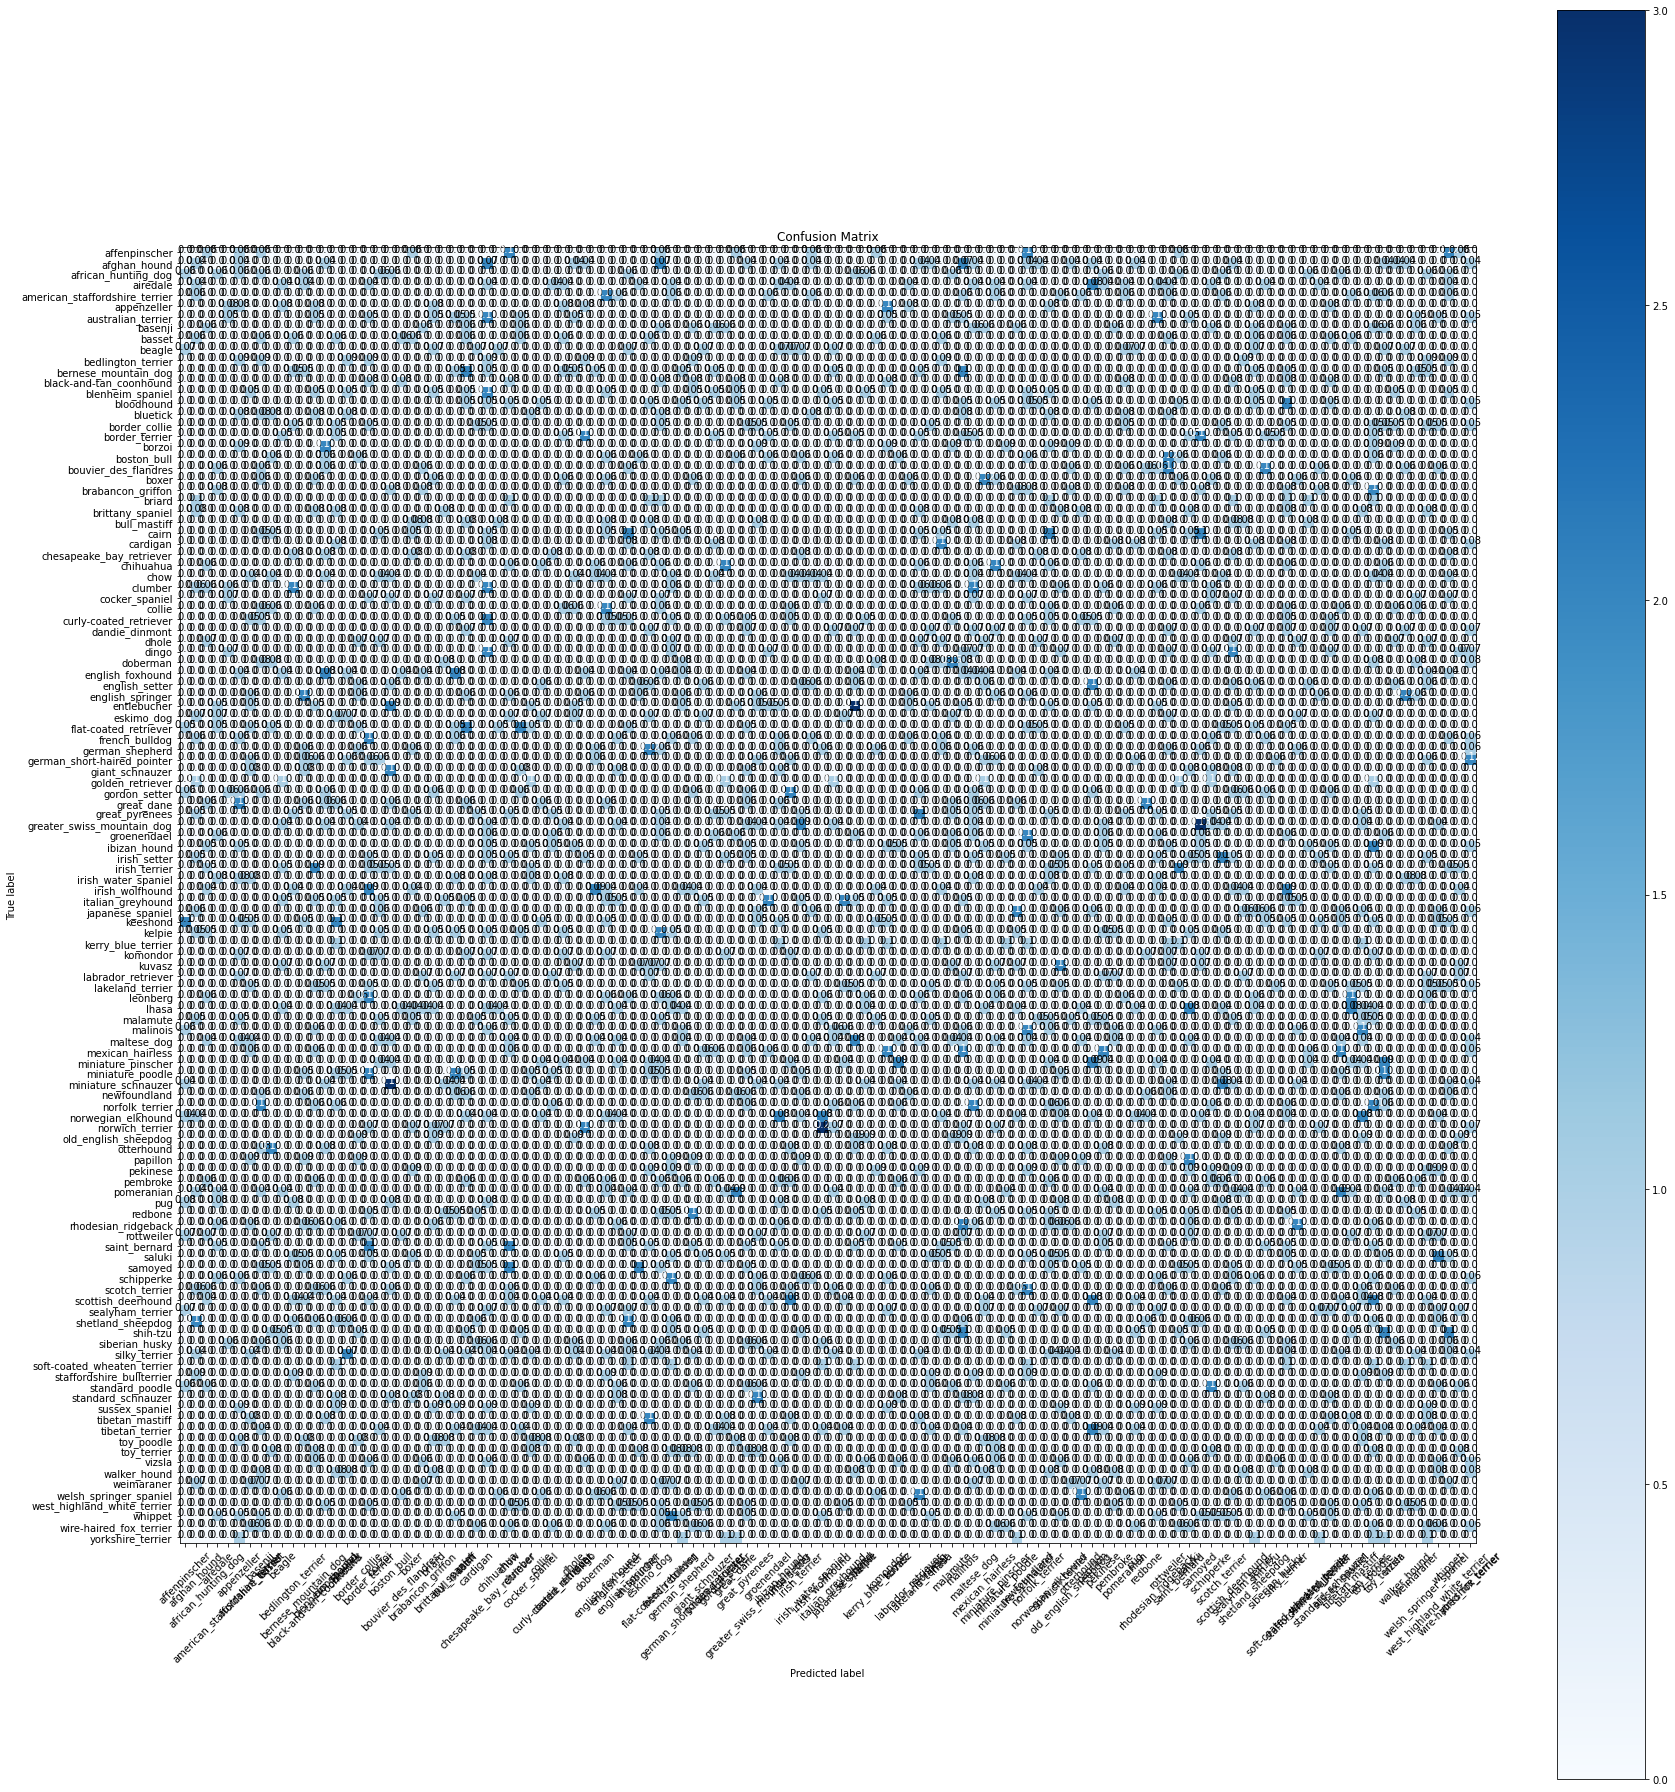

In [49]:
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# Visualizing The History Of training

In [50]:
import matplotlib.pyplot as plt

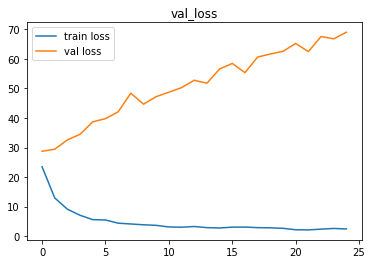

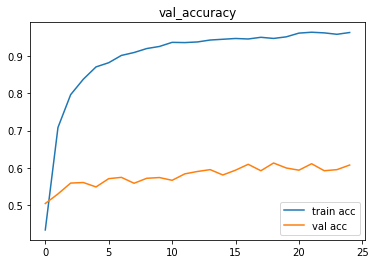

In [51]:

# plot the loss
plt.plot(a.history['loss'], label='train loss')
plt.plot(a.history['val_loss'], label='val loss')
plt.title('val_loss') 
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(a.history['accuracy'], label='train acc')
plt.plot(a.history['val_accuracy'], label='val acc')
plt.title('val_accuracy') 
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

### saving the tarined model

In [52]:
import tensorflow as tf

from keras.models import load_model

model.save('/content/drive/MyDrive/resnet50v2/fulldataresnet50v2.h5')

### Importing the test set

In [53]:
test_files = pd.read_csv("/content/drive/MyDrive/Assisgnment/sample_submission.csv")
test_files['id'] = test_files['id'] + '.jpg'
test_files.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1.jpg,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0

### Preprocessing the test set

In [54]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_data = test_gen.flow_from_dataframe(
    dataframe=test_files,
    directory='/content/drive/MyDrive/Assisgnment/test',
    x_col="id",
    y_col=None,
    target_size=(224, 224),
    class_mode=None,
    batch_size=32
)

Found 10357 validated image filenames.


### Making Predictions on Test set

In [55]:
preds = model.predict(test_data)

In [56]:
sub = pd.read_csv('/content/drive/MyDrive/Assisgnment/sample_submission.csv')
sub.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [57]:
import re

In [58]:
file_list = test_data.filenames
id_list = []
for name in file_list:
    m = re.sub('test/', '', name)
    m = re.sub('.jpg', '', m)
    id_list.append(m)

In [59]:
sub['id'] = id_list
sub.iloc[:,1:] = preds
sub.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00102ee9d8eb90812350685311fe5890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000061,0.0,0.0,0.0,0.0,0.999939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0012a730dfa437f5f3613fb75efcd4ce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.160991e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998783,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,001510bc8570bbeee98c8d80c8a95ec1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001a5f3114548acdefa3d4da05474c2e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.979154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.177700e-25,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Filtering selected breed scores

In [60]:
breeds=['id','beagle','chihuahua','doberman','french_bulldog', 'golden_retriever', 'malamute','pug','saint_bernard','scottish_deerhound','tibetan_mastiff']

In [61]:
selected_breeds = sub.loc[:,breeds]